# Saving intervals

* Find optimal saving intervals: Monthly vs biweekly vs weekly
* Check for ideal days of the week / month: 
    * If monthly: better to save at beginning, middle or end
    * If weekly, better to save at beginning, middle or end of the week

    

In [101]:
# General
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re

# File download
from tqdm.notebook import tqdm, trange

# Custom modules
from Tools import S3

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET

In [2]:
# Connect to AWS S3 storage
s3 = S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


In [3]:
# Get mapping data

# ETF Info - ISIN + Name + Description
etf_info = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/etf_info.tsv")

# ETF Info - ISIN to Symbol for Prices
etf_isin_symbol = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/etf_isin_symbol.tsv")

# Inspect for single-ETF portfolio

In [5]:
# Portfolio selection
portfolio = [

['IE00B4L5Y983', 1],	# iShares Core MSCI World UCITS ETF

]

df_pf = pd.DataFrame(portfolio, columns=['Security_ISIN', 'Weight'])

# Add more information
df_pf = df_pf.join(etf_info.set_index('Security_ISIN'), on=['Security_ISIN'])

df_pf.head()

,Security_ISIN,Weight,Security_Name,Security_Class,Fund_Company,Domicile,Type,Acc_Dist,Base_CCY
0,IE00B4L5Y983,1,iShares Core MSCI World UCITS ETF,ETF,iShares,Irland,Aktien,Acc,USD


In [6]:
# Get symbols for each security
df_prices = df_pf.join(etf_isin_symbol.set_index('Security_ISIN'), on='Security_ISIN')
df_prices = df_prices[['Security_ISIN', 'Weight', 'Sym_YahooFin']].rename(columns={'Sym_YahooFin':'Symbol'})
df_prices

,Security_ISIN,Weight,Symbol
0,IE00B4L5Y983,1,EUNL.DE


In [34]:
# Collect all price information for the portfolio

date_prices = "2022_04_15"

file_list = ["{dir}/{date}/{file}.tsv".format(**{'dir': 'data/price_raw', 'date': date_prices, 'file': sym}) for sym in df_prices.Symbol]

prices = pd.DataFrame(columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for key in file_list:

    data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

    # Subset columns
    cols = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = data[[i for i in cols if i in data.columns]]

    # Append 
    prices = prices.append(data)

# Store in data format readable by both Python and R
prices = prices.reset_index().drop(['index'], axis = 1)

prices.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,EUNL.DE,2014-01-02,28.650000,28.750000,28.559999,28.559999,8395.0
1,EUNL.DE,2014-01-03,28.620001,28.730000,28.620001,28.639999,57173.0
2,EUNL.DE,2014-01-06,28.690001,28.709999,28.480000,28.480000,2883.0
3,EUNL.DE,2014-01-07,28.620001,28.790001,28.620001,28.730000,17665.0
4,EUNL.DE,2014-01-08,28.770000,28.780001,28.730000,28.770000,32029.0


In [35]:
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index('Date')

In [46]:
# Fill missing values
prices = prices.resample('1D').ffill()

## Monthly

In [61]:
# Inspect monthly savings plan
# Invest on the first of every month

amount = 1000
day_of_month_start = 1

# Days when savings plan gets executed
df_savings = pd.DataFrame(pd.date_range('2014-02-01','2022-01-01' , freq='1M') - pd.offsets.MonthBegin(1) + timedelta(days=day_of_month_start - 1), columns=['Date'])

# Add prices per day
df_savings = df_savings.join(prices, on='Date')

# Calculate buying price: (high - low)
df_savings['Price'] = (df_savings['High'] + df_savings['Low']) / 2

# TODO: Transaction costs!!!!

# Calculate number of shares bought each day
df_savings['N'] = amount / df_savings['Price']

# Cumulative number of shares
df_savings['N_cum'] = df_savings.N.cumsum()

# Cumulative value of portfolio
df_savings['Value'] = df_savings['N_cum'] * df_savings['Close']

df_savings


,Date,Symbol,Open,High,Low,Close,Volume,Price,N,N_cum,Value
0,2014-02-01,EUNL.DE,28.059999,28.059999,27.820000,28.059999,16621.0,27.940000,35.790981,35.790981,1004.294914
1,2014-03-01,EUNL.DE,28.940001,28.940001,28.730000,28.920000,15369.0,28.835000,34.680076,70.471057,2038.022987
2,2014-04-01,EUNL.DE,29.010000,29.090000,28.940001,29.030001,2454.0,29.015000,34.464932,104.935989,3046.291832
3,2014-05-01,EUNL.DE,29.070000,29.070000,28.969999,29.020000,25169.0,29.020000,34.458994,139.394983,4045.242481
4,2014-06-01,EUNL.DE,30.150000,30.150000,30.100000,30.100000,3819.0,30.125000,33.195021,172.590004,5194.959190
...,...,...,...,...,...,...,...,...,...,...,...
90,2021-08-01,EUNL.DE,70.874001,71.375999,70.783997,71.216003,381670.0,71.079998,14.068655,2120.351773,151002.979147
91,2021-09-01,EUNL.DE,73.636002,73.713997,73.239998,73.334000,688671.0,73.476997,13.609701,2133.961475,156491.930022
92,2021-10-01,EUNL.DE,70.797997,71.655998,70.681999,71.566002,966811.0,71.168999,14.051062,2148.012537,153724.669270
93,2021-11-01,EUNL.DE,76.029999,76.194000,75.750000,75.888000,728295.0,75.972000,13.162744,2161.175281,164007.270773


In [93]:
# Compare value to keeping the money at: 0% / 1% / 2% / 5% / 10% / 15%/... interest


N = df_savings.shape[0]

# Nachschüssig
i = 0.01/12
df_savings['Value_0_perc'] = [amount * (((1 + i)**(n+1) - 1) / i) for n in range(N)]

i = 0.05/12
df_savings['Value_5_perc'] = [amount * (((1 + i)**(n+1) - 1) / i) for n in range(N)]

i = 0.10/12
df_savings['Value_10_perc'] = [amount * (((1 + i)**(n+1) - 1) / i) for n in range(N)]

# Vorschüssig
# amount * (((1 + i)**n - 1) / i) * (1+i)




<AxesSubplot:xlabel='Date', ylabel='Value'>

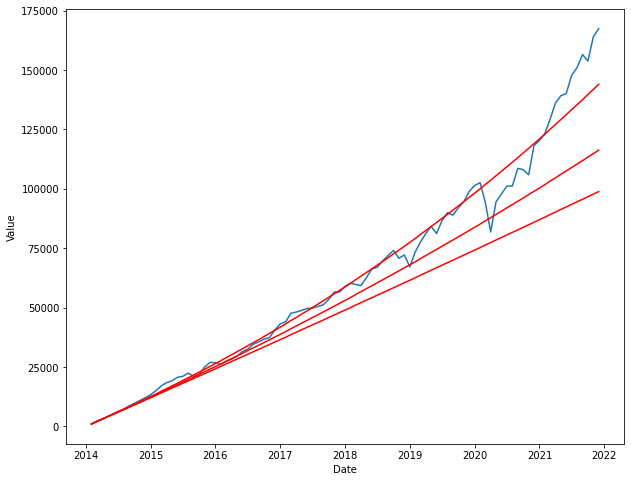

In [94]:
fig = plt.figure(figsize=(10,8))
# Value
sns.lineplot(data=df_savings,x='Date', y='Value')
# Benchmark
sns.lineplot(data=df_savings,x='Date', y='Value_0_perc', color='red')
sns.lineplot(data=df_savings,x='Date', y='Value_5_perc', color='red')
sns.lineplot(data=df_savings,x='Date', y='Value_10_perc', color='red')

## Metric for comparision over different time horizones

In [129]:
# Calculate relative return - in total / per year / per day
from pyxirr import xirr
# val = df_savings['Value']
# (val[len(val)-1] / val[0]) ** (1 / (len(val))) - 1

# IRR - invest only and sell everything at once at the end
val = df_savings['Value']
val_fin = val[len(val) - 1]

cf = [-amount] * len(val)
cf[len(cf)-1] += val_fin

irr = xirr(df_savings.Date, cf)


<AxesSubplot:xlabel='Date', ylabel='Value'>

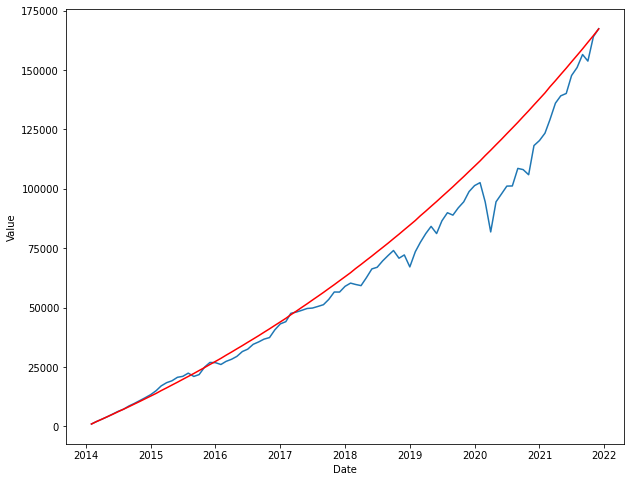

In [133]:
# Check plausibility of IRR calculations
i = (1 + irr) ** (1/12) - 1 
df_savings['Value_irr_perc'] = [amount * (((1 + i)**(n+1) - 1) / i) for n in range(N)]

fig = plt.figure(figsize=(10,8))
# Value
sns.lineplot(data=df_savings,x='Date', y='Value')
# Benchmark
sns.lineplot(data=df_savings,x='Date', y='Value_irr_perc', color='red')


## Vary day of month

In [217]:
# Set the parameters for the simulation

amount = 1000 # Amount saved per month
# amount_inc_pa = 1% # Increase of amount saved per month every year

day_of_month_start = [*range(1,29)] # Day of month when savings plan is executed
number_of_years = 5 # Number of years in simulation

n_windows = 20 # Number of timeshifts

month_start = datetime(2014, 2, 1)


# Collect IRR
irr_coll_m = {i: [] for i in day_of_month_start}

for i in range(n_windows):
    month_start_i = month_start + relativedelta(months=i)
    month_end = month_start_i +  relativedelta(years=number_of_years)

    for day_of_month in day_of_month_start:

        # Days when savings plan gets executed
        df_savings = pd.DataFrame(pd.date_range(month_start, month_end, freq='1M') - pd.offsets.MonthBegin(1) + timedelta(days=day_of_month - 1), columns=['Date'])

        # Add prices per day
        df_savings = df_savings.join(prices, on='Date')

        # Calculate buying price: (high - low)
        df_savings['Price'] = (df_savings['High'] + df_savings['Low']) / 2

        # TODO: Transaction costs!!!!

        # Calculate number of shares bought each day
        df_savings['N'] = amount / df_savings['Price']

        # Cumulative number of shares
        df_savings['N_cum'] = df_savings.N.cumsum()

        # Cumulative value of portfolio
        df_savings['Value'] = df_savings['N_cum'] * df_savings['Close']

        # Calculate IRR
        N = df_savings.shape[0]
        val = df_savings.loc[N-1, 'Value']

        cf = [-amount] * N
        cf[len(cf)-1] += val

        irr = xirr(df_savings.Date, cf)
        # irr_coll[day_of_month] = [irr_coll[day_of_month], irr]
        irr_coll_m.setdefault(day_of_month,[]).append(irr)
        # irr_coll.update({day_of_month: irr})

(0.07, 0.12)

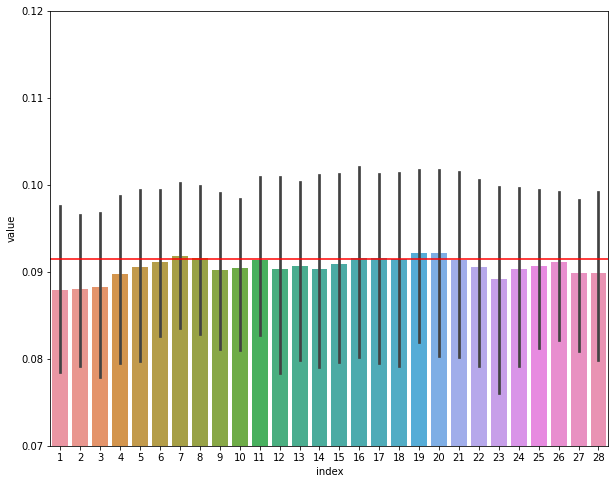

In [218]:
fig = plt.figure(figsize=(10,8))
# irr_coll
df_irr = pd.DataFrame.from_dict(irr_coll_m, orient='index').reset_index()
df_irr = df_irr.melt(id_vars='index')
df_irr
# df_irr.columns=['day', 'irr']
sns.barplot(data=df_irr, x='index', y='value')
plt.axhline(np.median(df_irr.value), color='red')
plt.ylim((0.07, 0.12))

## Weekly

In [215]:
amount = 1000 # Amount saved per month
# amount_inc_pa = 1% # Increase of amount saved per month every year

weekdays = [1,2,3,4,5] # Day of month when savings plan is executed
number_of_years = 5 # Number of years in simulation

n_windows = 20 # Number of timeshifts

month_start = datetime(2014, 2, 1)
month_end = month_start +  relativedelta(years=number_of_years)

# Collect IRR
irr_coll_w = {i: [] for i in weekdays}

for i in range(n_windows):
    month_start_i = month_start + relativedelta(months=i)
    month_end = month_start_i +  relativedelta(years=number_of_years)

    for weekday in weekdays:

        # Days when savings plan gets executed
        # Start with a monday !
        df_savings = pd.DataFrame(pd.date_range(month_start, month_end, freq='W-MON') + timedelta(days=weekday), columns=['Date'])

        # Add prices per day
        df_savings = df_savings.join(prices, on='Date')

        # Calculate buying price: (high - low)
        df_savings['Price'] = (df_savings['High'] + df_savings['Low']) / 2

        # TODO: Transaction costs!!!!

        # Calculate number of shares bought each day
        df_savings['N'] = amount / df_savings['Price']

        # Cumulative number of shares
        df_savings['N_cum'] = df_savings.N.cumsum()

        # Cumulative value of portfolio
        df_savings['Value'] = df_savings['N_cum'] * df_savings['Close']

        # Calculate IRR
        N = df_savings.shape[0]
        val = df_savings.loc[N-1, 'Value']

        cf = [-amount] * N
        cf[len(cf)-1] += val

        irr = xirr(df_savings.Date, cf)
        # irr_coll[day_of_month] = [irr_coll[day_of_month], irr]
        irr_coll_w.setdefault(weekday,[]).append(irr)
        # irr_coll.update({day_of_month: irr})


(0.07, 0.12)

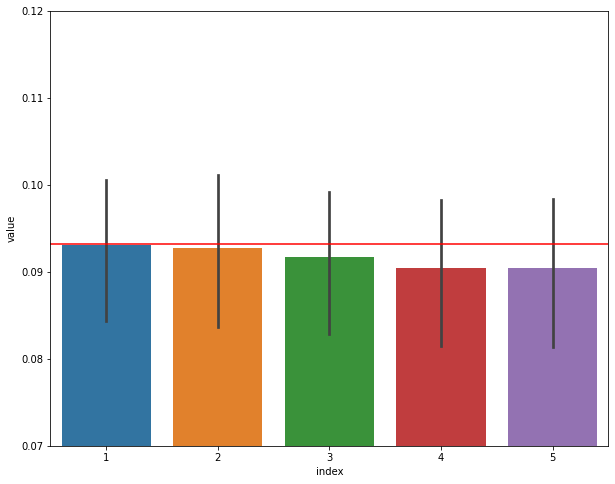

In [216]:
fig = plt.figure(figsize=(10,8))
# irr_coll_w
df_irr = pd.DataFrame.from_dict(irr_coll_w, orient='index').reset_index()
df_irr = df_irr.melt(id_vars='index')
df_irr
# df_irr.columns=['day', 'irr']
sns.barplot(data=df_irr, x='index', y='value')
plt.axhline(np.median(df_irr.value), color='red')
plt.ylim((0.07, 0.12))

## Compare monthly vs weekly

boxplot / violinplot, ...

In [228]:
print((np.median(list(irr_coll_w.values())), np.median(list(irr_coll_m.values()))))

(0.09322834288148428, 0.09149493768355299)


<AxesSubplot:ylabel='Density'>

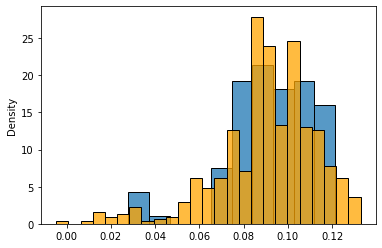

In [243]:
from itertools import chain
sns.histplot(x = list(chain(*list(irr_coll_w.values()))), stat='density')
sns.histplot(x = list(chain(*list(irr_coll_m.values()))), color='orange', stat='density')